In [9]:
# need to check bias term
# need to check regularization term
# recurrent connection is all zero 


import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_fullRank import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

import torch

In [10]:
size = 400
noise_std = 1e-2
alpha = .1
lr = 1e-3

input_size = 3
output_size = 1


In [11]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(10000)


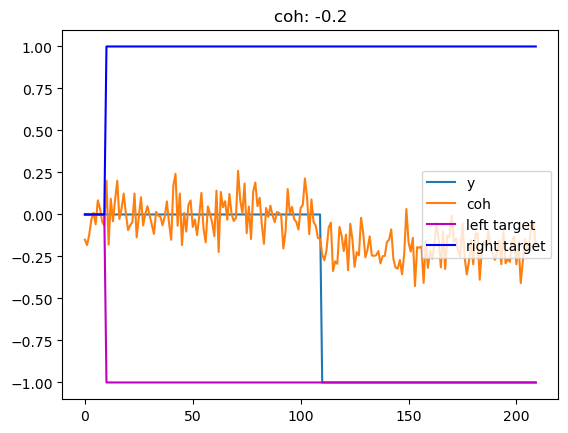

In [12]:
n = 8

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], 'm', label = 'left target')
plt.plot(x_val[n,:,2], 'b', label = 'right target')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()




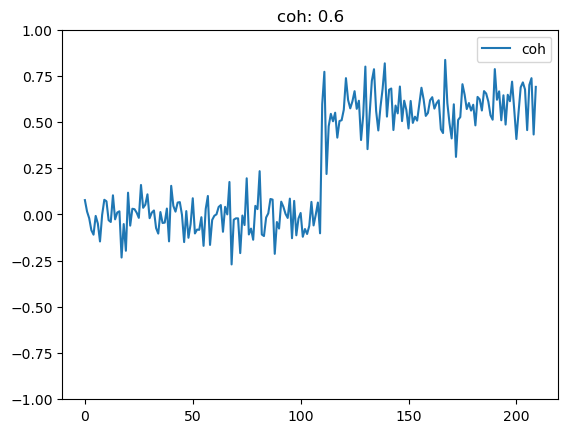

In [20]:
n = 1

# plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
# plt.plot(x_val[n,:,1], 'm', label = 'left target')
# plt.plot(x_val[n,:,2], 'b', label = 'right target')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()
plt.ylim([-1, 1])
plt.savefig("/home/tianwang/Desktop/input_col.svg", format = 'svg', dpi = 300)


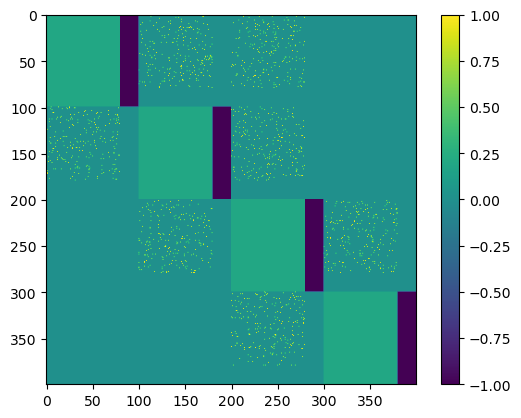

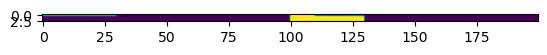

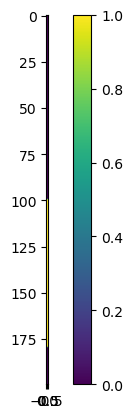

In [16]:

# local connections are continuous 
def create_local_conn(Inum, ratio, n_neurons):
    mask_rec = torch.zeros(n_neurons, n_neurons)
	    
    mask_rec[:,n_neurons-Inum:] = -1
	    
    mask_rec[:,:n_neurons-Inum] = ratio    

    return mask_rec



def create_area_conn(Inum, ratio, n_neurons): 
    mask_rec = torch.zeros(n_neurons, n_neurons)
	    
    mask_rec[:,n_neurons-Inum:] = 0
    mask_rec[n_neurons-Inum:,:] = 0
	    
	    # Define the size of the matrix
    rows, cols = n_neurons-Inum, n_neurons-Inum
	    
	    # Create a zero matrix
    matrix = torch.zeros(rows, cols)
	    
	    # Calculate the number of entries to set to 1
    num_entries = int(ratio * rows * cols)
	    
	    # Randomly select indices
    indices = torch.randperm(rows * cols)[:num_entries]
	    
	    # Set the selected entries to 1
    matrix.view(-1)[indices] = 1
	    
    mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

    return mask_rec







# Visualize V3 framework
# n_neurons = 400
# n_inputs = 3
# n_outputs = 1


# mask_rec = torch.zeros(n_neurons, n_neurons)
# mask_in = torch.zeros(n_inputs, n_neurons)
# mask_out = torch.ones(n_neurons, n_outputs)


# mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
# mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
# mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)
# mask_rec[300:400,300:400] = create_local_conn(20,0.2,100)


# connStrength = 0.0357


# mask_rec[:100,100:200] = create_area_conn(20,connStrength,100)



# mask_rec[100:200,0:100] = create_area_conn(20,connStrength,100)

# mask_rec[100:200,200:300] = create_area_conn(20,connStrength,100)

# mask_rec[200:300,100:200] = create_area_conn(20,connStrength,100)



# mask_rec[200:300,300:400] = create_area_conn(20,connStrength,100)
# mask_rec[300:400,200:300] = create_area_conn(20,connStrength,100)


# mask_rec[0:100,200:300] = create_area_conn(20,connStrength,100)





# mask_in[0,:30] = 1
# mask_in[1:,:10] = 1

# mask_in[1:,100:130] = 1
# mask_in[0,100:110] = 1


# mask_out[:300,:] = 0
# mask_out[380:,:] = 0


# Visualize V2 framework
n_neurons = 400
n_inputs = 3
n_outputs = 1


mask_rec = torch.zeros(n_neurons, n_neurons)
mask_in = torch.zeros(n_inputs, n_neurons)
mask_out = torch.ones(n_neurons, n_outputs)


mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)
mask_rec[300:400,300:400] = create_local_conn(20,0.2,100)


connStrength = 0.0357


mask_rec[:100,100:200] = create_area_conn(20,connStrength,100)



mask_rec[100:200,0:100] = create_area_conn(20,connStrength,100)

mask_rec[100:200,200:300] = create_area_conn(20,connStrength,100)

mask_rec[200:300,100:200] = create_area_conn(20,connStrength,100)



mask_rec[200:300,300:400] = create_area_conn(20,connStrength,100)
mask_rec[300:400,200:300] = create_area_conn(20,connStrength,100)


mask_rec[0:100,200:300] = create_area_conn(20,connStrength,100)






mask_in[0,:30] = 1
	# mask_in[1:,:10] = 1

mask_in[1:,100:130] = 1
mask_in[0,100:110] = 1


mask_out[:300,:] = 0
mask_out[380:,:] = 0



wi_mask = mask_in
wo_mask = mask_out
wrec_mask = mask_rec.t()



wi_mask = mask_in
wo_mask = mask_out
wrec_mask = mask_rec.t()

plt.imshow(mask_rec, cmap = 'viridis')
plt.colorbar()
plt.show()

plt.imshow(wi_mask[:,:200])
plt.show()
plt.imshow(wo_mask[200:])
plt.colorbar()
plt.show()


In [54]:
# # local connections are sparce
# # def create_local_conn(Inum, ratio, n_neurons):

# #     mask_rec = torch.zeros(n_neurons, n_neurons)
    
# #     mask_rec[:,n_neurons-Inum:] = -1
    
# #     # Define the size of the matrix
# #     rows, cols = n_neurons, n_neurons-Inum
    
# #     # Create a zero matrix
# #     matrix = torch.zeros(rows, cols)
    
# #     # Calculate the number of entries to set to 1
# #     num_entries = int(ratio * rows * cols)
    
# #     # Randomly select indices
# #     indices = torch.randperm(rows * cols)[:num_entries]
    
# #     # Set the selected entries to 1
# #     matrix.view(-1)[indices] = 1
    
# #     mask_rec[:,:n_neurons-Inum] = matrix    

# #     return mask_rec

# # local connections are continuous 
# def create_local_conn(Inum, ratio, n_neurons):

#     mask_rec = torch.zeros(n_neurons, n_neurons)
    
#     mask_rec[:,n_neurons-Inum:] = -1
    
#     mask_rec[:,:n_neurons-Inum] = ratio    

#     return mask_rec



# def create_area_conn(Inum, ratio, n_neurons): 
#     mask_rec = torch.zeros(n_neurons, n_neurons)
    
#     mask_rec[:,n_neurons-Inum:] = 0
#     mask_rec[n_neurons-Inum:,:] = 0
    
#     # Define the size of the matrix
#     rows, cols = n_neurons-Inum, n_neurons-Inum
    
#     # Create a zero matrix
#     matrix = torch.zeros(rows, cols)
    
#     # Calculate the number of entries to set to 1
#     num_entries = int(ratio * rows * cols)
    
#     # Randomly select indices
#     indices = torch.randperm(rows * cols)[:num_entries]
    
#     # Set the selected entries to 1
#     matrix.view(-1)[indices] = 1
    
#     mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

#     return mask_rec


# def create_area_conn1(ratio, rows, cols): 
    
#     # Create a zero matrix
#     matrix = torch.zeros(rows, cols)
    
#     # Calculate the number of entries to set to 1
#     num_entries = int(ratio * rows * cols)
    
#     # Randomly select indices
#     indices = torch.randperm(rows * cols)[:num_entries]
    
#     # Set the selected entries to 1
#     matrix.view(-1)[indices] = 1
    

#     return matrix

# # # areal connections are continuous 
# # def create_area_conn(Inum, ratio, n_neurons): 
# #     mask_rec = torch.zeros(n_neurons, n_neurons)
    
# #     mask_rec[:,n_neurons-Inum:] = 0
# #     mask_rec[n_neurons-Inum:,:] = 0
    
    
# #     mask_rec[:n_neurons-Inum,:n_neurons-Inum] = ratio

# #     return mask_rec



# n_neurons = 400
# n_inputs = 3
# n_outputs = 1


# mask_rec = torch.zeros(n_neurons, n_neurons)
# mask_in = torch.zeros(n_inputs, n_neurons)
# mask_out = torch.ones(n_neurons, n_outputs)


# mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
# mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
# mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)
# mask_rec[300:400,300:400] = create_local_conn(20,0.2,100)


# connStrength = 0.0417

# # area2 to 1 feedback
# mask_rec[:100,100:200] = create_area_conn(20,connStrength,100)


# # area1 to 2 feedforward
# # mask_rec[100:200,0:100] = create_area_conn(20,connStrength,100)
# # mask_rec[100:200,0:40] = 0
# mask_rec[100:180,40:80] = create_area_conn1(connStrength, 80,40)


# # area3to 2 feedback
# mask_rec[100:200,200:300] = create_area_conn(20,connStrength,100)


# # area2 to 3 feedforward
# # mask_rec[200:300,100:200] = create_area_conn(20,connStrength,100)
# # mask_rec[200:300,100:140] = 0
# mask_rec[200:280,140:180] = create_area_conn1(connStrength,80,40)



# # area3 to 4 feedback
# mask_rec[200:300,300:400] = create_area_conn(20,connStrength,100)


# # area3 to 4 feedforward
# mask_rec[300:400,200:300] = create_area_conn(20,connStrength,100)


# # area3 to 1 feedback
# mask_rec[0:100,200:300] = create_area_conn(20,connStrength,100)





# mask_in[0,:30] = 1
# mask_in[1:,:10] = 1


# mask_in[1:,100:130] = 1
# mask_in[0,100:110] = 1

# # mask_in[:,:80] = 1


# mask_out[:300,:] = 0
# mask_out[380:,:] = 0


# wi_mask = mask_in
# wo_mask = mask_out
# wrec_mask = mask_rec.t()

# plt.imshow(mask_rec, cmap = 'viridis')
# plt.colorbar()
# plt.show()

# plt.imshow(wi_mask[:,:200])
# plt.show()
# plt.imshow(wo_mask)
# plt.colorbar()
# plt.show()


# print(torch.sum(wrec_mask))

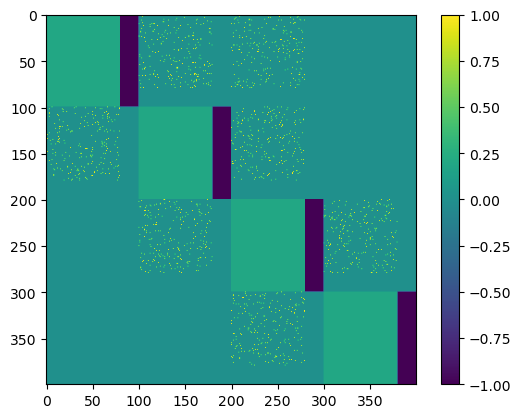

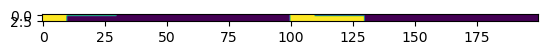

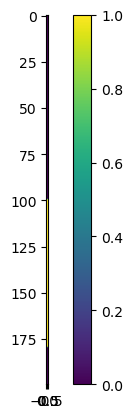

tensor(-4.)


In [64]:

# local connections are continuous 
def create_local_conn(Inum, ratio, n_neurons):

    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = -1
    
    mask_rec[:,:n_neurons-Inum] = ratio    

    return mask_rec



def create_area_conn(Inum, ratio, n_neurons): 
    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = 0
    mask_rec[n_neurons-Inum:,:] = 0
    
    # Define the size of the matrix
    rows, cols = n_neurons-Inum, n_neurons-Inum
    
    # Create a zero matrix
    matrix = torch.zeros(rows, cols)
    
    # Calculate the number of entries to set to 1
    num_entries = int(ratio * rows * cols)
    
    # Randomly select indices
    indices = torch.randperm(rows * cols)[:num_entries]
    
    # Set the selected entries to 1
    matrix.view(-1)[indices] = 1
    
    mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

    return mask_rec




n_neurons = 400
n_inputs = 3
n_outputs = 1


mask_rec = torch.zeros(n_neurons, n_neurons)
mask_in = torch.zeros(n_inputs, n_neurons)
mask_out = torch.ones(n_neurons, n_outputs)


mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)
mask_rec[300:400,300:400] = create_local_conn(20,0.2,100)


connStrength = 0.0357


mask_rec[:100,100:200] = create_area_conn(20,connStrength,100)



mask_rec[100:200,0:100] = create_area_conn(20,connStrength,100)

mask_rec[100:200,200:300] = create_area_conn(20,connStrength,100)

mask_rec[200:300,100:200] = create_area_conn(20,connStrength,100)



mask_rec[200:300,300:400] = create_area_conn(20,connStrength,100)
mask_rec[300:400,200:300] = create_area_conn(20,connStrength,100)


mask_rec[0:100,200:300] = create_area_conn(20,connStrength,100)





mask_in[0,:30] = 1
mask_in[1:,:10] = 1

mask_in[1:,100:130] = 1
mask_in[0,100:110] = 1


mask_out[:300,:] = 0
mask_out[380:,:] = 0










wi_mask = mask_in
wo_mask = mask_out
wrec_mask = mask_rec.t()

plt.imshow(mask_rec, cmap = 'viridis')
plt.colorbar()
plt.show()

plt.imshow(wi_mask[:,:200])
plt.show()
plt.imshow(wo_mask[200:])
plt.colorbar()
plt.show()


print(torch.sum(wrec_mask))

tensor(21.2107)

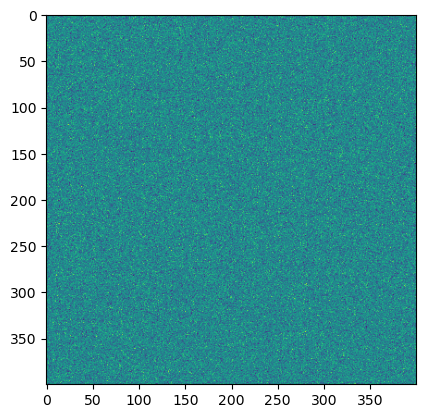

In [20]:
temp3 = torch.normal(0,1 / sqrt(size),size = (400,400))
# wrec_init = (np.abs(temp3)*wrec_mask) 
plt.imshow(wrec_init)
torch.sum(wrec_init)

In [8]:

net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
                  wrec_mask = wrec_mask, wi_mask = wi_mask, wo_mask = wo_mask, 
                 b_init = None, add_biases = False)



# after trained, recurrent connectivity are all zero
# after trained, bias term will make test accuracy very low
net.non_linearity = torch.relu
net.out_non_linearity = torch.relu

# net.out_non_linearity = torch.eye

train(net, x_train, y_train, mask_train, n_epochs=50, lr=lr, batch_size=100, 
      mask_gradients = False, keep_best=True, cuda=True, early_stop=0.25, clip_gradient = 1)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)


loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

Training...
initial loss: 1.000
epoch 0:  loss=1.000  (took 14.52 s) *
epoch 1:  loss=0.983  (took 14.03 s) *
epoch 2:  loss=0.839  (took 13.87 s) *
epoch 3:  loss=0.727  (took 14.10 s) *
epoch 4:  loss=0.677  (took 13.89 s) *
epoch 5:  loss=0.475  (took 13.88 s) *
epoch 6:  loss=0.341  (took 13.76 s) *
epoch 7:  loss=0.296  (took 13.92 s) *
epoch 8:  loss=0.273  (took 13.64 s) *
epoch 9:  loss=0.251  (took 13.52 s) *
epoch 10:  loss=0.243  (took 13.50 s) *
loss=0.247, acc=1.000


In [9]:
attributes = net.__dict__

In [10]:
attributes.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'input_size', 'hidden_size', 'output_size', 'noise_std', 'alpha', 'rho', 'train_wi', 'train_wo', 'train_wrec', 'train_h0', 'train_si', 'train_so', 'non_linearity', 'output_non_linearity', 'wi_full', 'wo_full', 'out_non_linearity', 'w_rec_eff', 'w_in_eff', 'w_out_eff'])

In [11]:
attributes['non_linearity']

<function torch._VariableFunctionsClass.relu>

In [12]:
# # or load a RNN


# import sys
# sys.path.append('../')

# from low_rank_rnns.modules_connectivity_fullRank import *
# from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

# from matplotlib import pyplot as plt
# # %matplotlib notebook
# import random
# import numpy as np

# import torch
# size = 400
# noise_std = 1e-2
# alpha = .1
# lr = 1e-3

# input_size = 3
# output_size = 1

# # load a full-rank RNN
# net = FullRankRNN(3, size, 1, noise_std, alpha)
# net.load_state_dict(torch.load(f'../models/4areas3.pt', map_location='cpu'))


# # with torch.no_grad():
# #     net1.wi.copy_(net.w_in_eff)
# #     net1.wo.copy_(net.w_out_eff)
# #     net1.wrec.copy_(net.w_rec_eff)


# x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

# loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
# print(f'loss={loss:.3f}, acc={acc:.3f}')

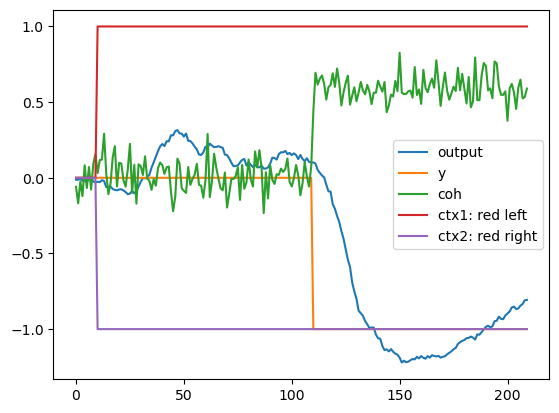

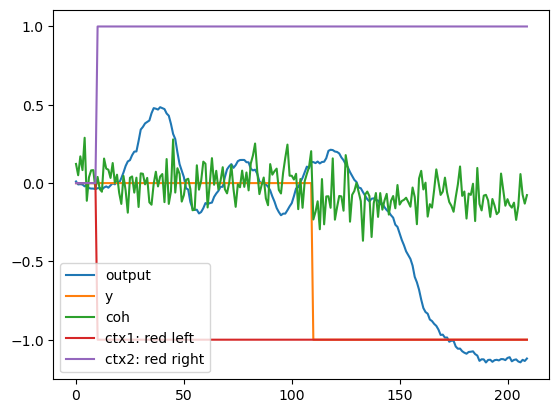

In [13]:
out = out.cpu()
y_val = y_val.cpu()
x_val = x_val.cpu()


for n in range(1, 3):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot psth

In [14]:
traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

In [37]:
for n in range(200, 220):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

NameError: name 'tfRL' is not defined

<Figure size 640x480 with 0 Axes>

In [38]:
for n in range(70, 80):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

NameError: name 'tfRL' is not defined

<Figure size 640x480 with 0 Axes>

tensor(-52.7727)


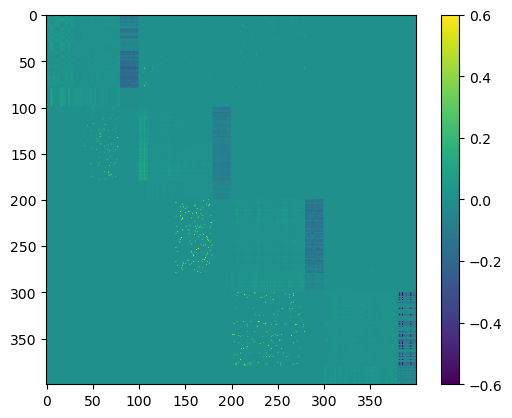

In [47]:

# load a full-rank RNN
net = FullRankRNN(3, size, 1, noise_std, alpha)
net.load_state_dict(torch.load(f'../models/4AreasA5_0.pt', map_location='cpu'))


a = net.wrec_mask.cpu()
a = a.detach().numpy()

b = net.wrec.cpu()
b = b.detach().numpy()
c = np.abs(b)*a
plt.imshow(np.transpose(c), vmin=-0.6, vmax=0.6)
plt.colorbar()

tensor(-24.9331)


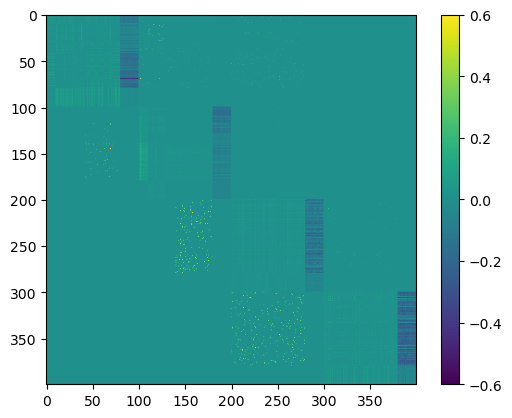

In [49]:
# load a full-rank RNN
net = FullRankRNN(3, size, 1, noise_std, alpha)
net.load_state_dict(torch.load(f'../models/4AreasA5_1.pt', map_location='cpu'))


a = net.wrec_mask.cpu()
a = a.detach().numpy()

b = net.wrec.cpu()
b = b.detach().numpy()
c = np.abs(b)*a
plt.imshow(np.transpose(c), vmin=-0.6, vmax=0.6)
plt.colorbar()

# plot the connectivity matrix


In [23]:
wrec = net.w_rec_eff.cpu()
wi = net.w_in_eff.cpu()
wo = net.w_out_eff.cpu()

a = wrec.detach().numpy()
plt.imshow(np.transpose(a))
plt.colorbar()
plt.set_cmap('viridis')
plt.clim(-0.1, 0.1)
plt.show()

b = wi.detach().numpy()
plt.imshow(b[:,:200])
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

c = wo.detach().numpy()
plt.imshow(c[300:])
plt.colorbar()
plt.set_cmap('viridis')
plt.show()


AttributeError: 'FullRankRNN' object has no attribute 'w_rec_eff'

In [25]:
# save the model
# torch.save(net.state_dict(), f'../models/4Areas3to1.pt')

In [50]:
trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

In [51]:
a = np.mean(tfRL,axis = 0)
b = np.mean(tfRR,axis = 0)
c = np.mean(tfGL,axis = 0)
d = np.mean(tfGR,axis = 0)

psth = np.concatenate((a,b,c,d), axis=0) # error!
psth.shape

(844, 400)

In [52]:
# # low rank RNN PCA 

# def areaPCA(trajLow):
#     TOn = 10
#     COn = 100
    
#     pca = plot.pca_cumvar(trajLow, n_components=10)
#     plt.ylim(0, 1.02)
#     plt.axhline(1, ls='--', c='gray')
#     plt.show()
    
#     labels = ['RL', 'RR', 'GL', 'GR']
#     colors = ['red', 'red', 'green', 'green']
#     lineStyle = ['-', '--', '-', '--']
    
#     ax1 = pca.components_[0]
#     ax2 = pca.components_[1]
#     ax3 = pca.components_[2]
#     ax4 = pca.components_[3]
    
#     k1 = trajLow @ ax1
#     k2 = trajLow @ ax2
#     k3 = trajLow @ ax3
#     k4 = trajLow @ ax4
    
#     plt.figure()
#     for i in range(4):
#     #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
#         plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
#     plt.show()
    
#     plt.figure()
#     for i in range(4):
#     #      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
#         plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
#     plt.show()
    
#     plt.figure()
#     for i in range(4):
#         plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
#     plt.show()
    
#     plt.figure()
#     for i in range(4):
#         plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
#     plt.show()
    
#     # 3D pca plot
#     from mpl_toolkits.mplot3d import Axes3D
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     for i in range(4):
#         plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, ls = lineStyle[i])
#         ax.scatter(k1[i, TOn], k2[i, TOn], k3[i, TOn], c='black',
#                 marker='.', s=400)
#         ax.scatter(k1[i, COn], k2[i, COn], k3[i, COn], c= 'magenta',
#                 marker='.', s=400)
#     ax.axis('equal')

# # area 1:
# areaPCA(trajLow[:,:,200:300])
# # area 2:
# # areaPCA(trajLow[:,:,100:200])
# # area 3:
# # areaPCA(trajLow[:,:,200:])

In [54]:
area = np.arange(0,400)

dim = trajLow.shape
firingRatesAverage = np.zeros((400,2,2,dim[1]))

firingRatesAverage[:,0,0,:] = (trajLow[0,:,area])
firingRatesAverage[:,0,1,:] = (trajLow[1,:,area])
firingRatesAverage[:,1,0,:] = (trajLow[2,:,area])
firingRatesAverage[:,1,1,:] = (trajLow[3,:,area])


In [55]:
firingRatesAverage.shape

(400, 2, 2, 211)

In [56]:
from scipy.io import savemat
mdic = {"firingRatesAverage": firingRatesAverage}
savemat("../fr/jul29.mat", mdic)


In [31]:
firingRatesAverage.shape

(400, 2, 2, 211)